In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

from numpy import genfromtxt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from astropy.coordinates import EarthLocation, AltAz
from astropy import coordinates as coordinates
from astropy import units as u
from astropy.time import Time

from skyfield.api import load, wgs84

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# Build a timescale for SkyField calculations
#ts = load.timescale(builtin=False) #https://maia.usno.navy.mil/ser7/finals2000A.daily.extended
ts = load.timescale(builtin=True)

# Load TLEs for geostationary satellites visible from Rubin
EUTELSAT_117W_A = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=39122&FORMAT=TLE' 
EUTELSAT_117W_B = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=41589&FORMAT=TLE' #Part of GPS/WAAS
GOES_16 = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=41866&FORMAT=TLE'
STARONE_C3 = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=38991&FORMAT=TLE'
ASCENT = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=51287&FORMAT=TLE'

# Live loading
eutel_sat_a = load.tle_file(EUTELSAT_117W_A, reload=True, filename='eutel_sat_a.txt')[0]
eutel_sat_b = load.tle_file(EUTELSAT_117W_B, reload=True, filename='eutel_sat_b.txt')[0]
goes_16 = load.tle_file(GOES_16, reload=True, filename='goes_16.txt')[0]
starone_c3 = load.tle_file(STARONE_C3, reload=True, filename='star-one.txt')[0]
ascent = load.tle_file(ASCENT, reload=True, filename='ascent.txt')[0]

# Preloaded
home_dir = '/Users/walter/'
home_dir = '/sdf/home/c/cwalter/'

#eutel_sat_a = load.tle_file(EUTELSAT_117W_A, reload=False, filename=home_dir+'TLE/sat_a-2024-04-23.txt')[0]
#eutel_sat_b = load.tle_file(EUTELSAT_117W_B, reload=False, filename=home_dir+'TLE/sat_b-2024-04-23.txt')[0]
###goes_16 = load.tle_file(GOES_16, reload=False, filename=home_dir+'TLE/goes-2024-04-22.txt')[0]
###goes_16 = load.tle_file(GOES_16, reload=False, filename=home_dir+'TLE/goes-2024-04-23.txt')[0]
#goes_16 = load.tle_file(GOES_16, reload=False, filename=home_dir+'TLE/new-TLE.txt')[0]
#starone_c3 = load.tle_file(STARONE_C3, reload=False, filename=home_dir+'TLE/star-one-23.txt')[0]
#ascent = load.tle_file(ASCENT, reload=False, filename=home_dir+'TLE/ascent-23.txt')[0]


[#################################] 100% eutel_sat_a.txt
[#################################] 100% eutel_sat_b.txt
[#################################] 100% goes_16.txt
[#################################] 100% star-one.txt
[#################################] 100% ascent.txt


In [3]:
# Check epoch of the satellites
print(f'{eutel_sat_a.name} last updated on \t {eutel_sat_a.epoch.utc_jpl()}')
print(f'{eutel_sat_b.name} last updated on \t {eutel_sat_b.epoch.utc_jpl()}')
print(f'{goes_16.name} last updated on \t\t {goes_16.epoch.utc_jpl()}')
print(f'{starone_c3.name} last updated on \t\t {starone_c3.epoch.utc_jpl()}')
print(f'{ascent.name} last updated on \t\t\t {ascent.epoch.utc_jpl()}')

EUTELSAT 117 WEST A last updated on 	 A.D. 2025-May-22 13:35:19.1184 UTC
EUTELSAT 117 WEST B last updated on 	 A.D. 2025-May-22 11:52:32.0816 UTC
GOES 16 last updated on 		 A.D. 2025-May-22 12:52:08.3444 UTC
STAR ONE C3 last updated on 		 A.D. 2025-May-22 10:21:41.6163 UTC
ASCENT last updated on 			 A.D. 2025-May-22 03:26:37.8272 UTC


In [4]:
# Set the location of the observatory 
rubin_obs = coordinates.EarthLocation.of_site('Rubin Observatory')
# la_serena = wgs84.latlon(-29.9045, -71.2489, 67.056)  # Alternative 

Rubin= wgs84.latlon(rubin_obs.lat.deg, rubin_obs.lon.deg, rubin_obs.height.value)

In [5]:
# Get the position of the satellites at a given time(s)

start_day = 22
end_day = 23

start = ts.utc(2025, 5, start_day, 23, 0, 0)
stop  = ts.utc(2025, 5, end_day,  23, 0, 0)    

time_array = ts.linspace(start, stop, (end_day - start_day)*2*24)

eutel_sat_a_position = eutel_sat_a.at(time_array)
eutel_sat_b_position = eutel_sat_b.at(time_array)
goes_16_position = goes_16.at(time_array)

wgs84.latlon_of(eutel_sat_b_position)

(<Angle 48 values from -00deg 00' 01.3" to -00deg 00' 01.9">,
 <Angle 48 values from -116deg 59' 29.6" to -116deg 58' 56.1">)

In [6]:
# Set the pressure and temperature to use for refraction
# Call .altaz() with no parameters to ignore the atmosphere.
# 
# The differences with and w/o atmosphere range from 40" to 100" for GOES-16
# and EUTELSAT 117W B respectively.  Trying to match the Stellarium atmosphere 
# achieves agreement within ~ 2" for EUTELSAT 117W B.

# Default skyfield Atmosphere
pressure, temp = 'standard', 'standard'

# To match Stellarium Atmosphere
#pressure, temp = 1013.25, 15.0

In [7]:
# Calculate Alt,Az of satellites
eutel_a_alt, eutel_a_az, eutel_a_dist = (eutel_sat_a - Rubin).at(time_array).altaz()
eutel_b_alt, eutel_b_az, eutel_b_dist = (eutel_sat_b - Rubin).at(time_array).altaz()
goes_16_alt, goes_16_az, goes_16_dist = (goes_16 - Rubin).at(time_array).altaz()
ascent_alt, ascent_az, ascent_dist = (ascent - Rubin).at(time_array).altaz()

# Calculate RA, Dec of satellites
eutel_a_ra, eutel_a_dec, eutel_a_dist = (eutel_sat_a - Rubin).at(time_array).radec()
eutel_b_ra, eutel_b_dec, eutel_b_dist = (eutel_sat_b - Rubin).at(time_array).radec()
goes_16_ra, goes_16_dec, goes_16_dist = (goes_16 - Rubin).at(time_array).radec()
ascent_ra, ascent_dec, ascent_dist = (ascent - Rubin).at(time_array).radec()

In [8]:
# If things go out of range this message well tell us why
#eutel_sat_a_position.message

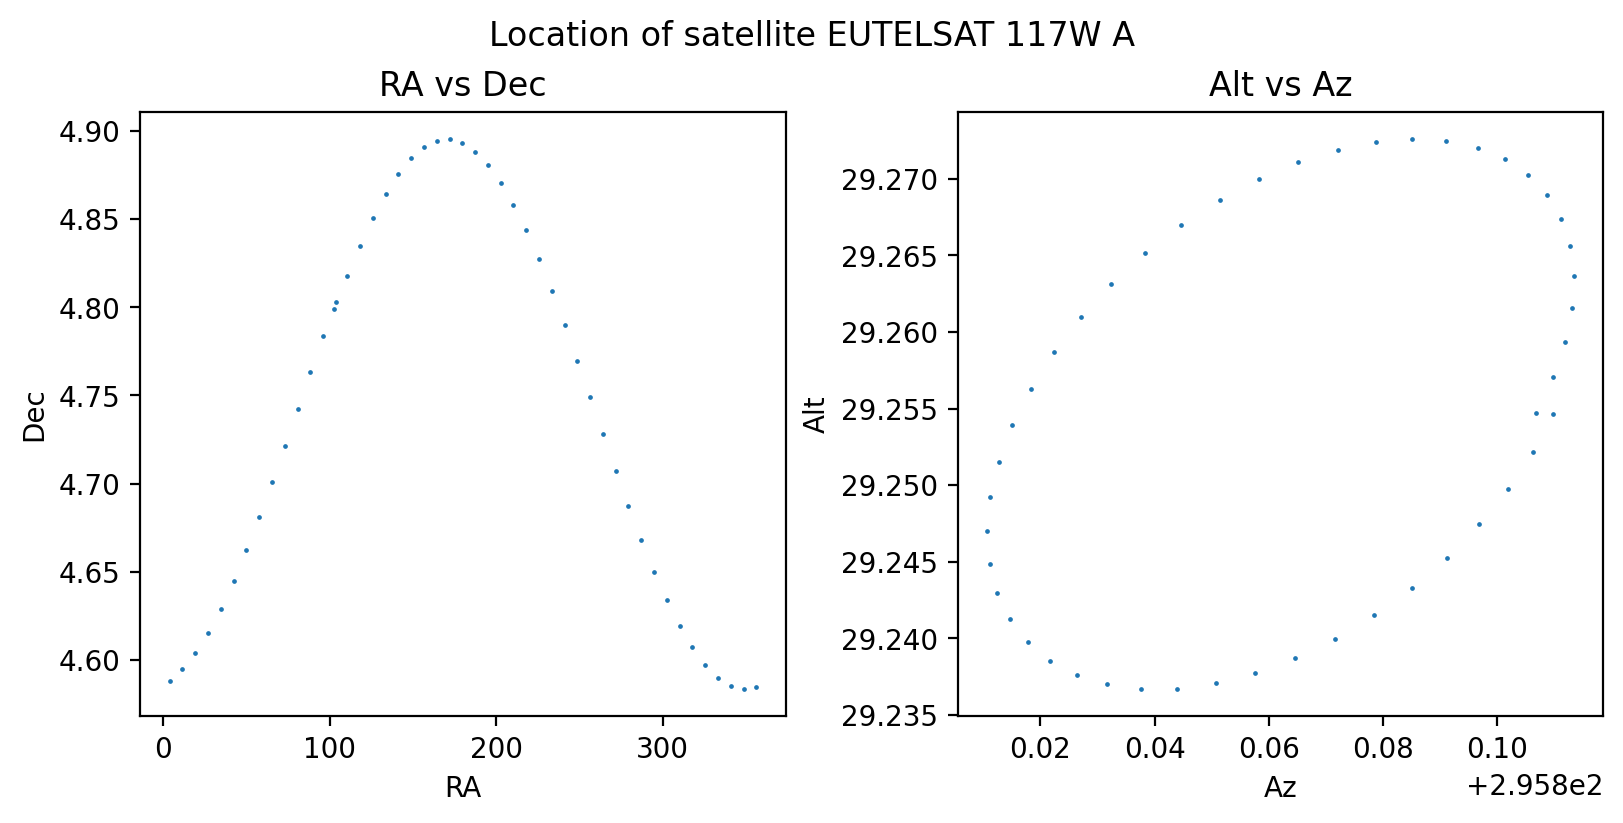

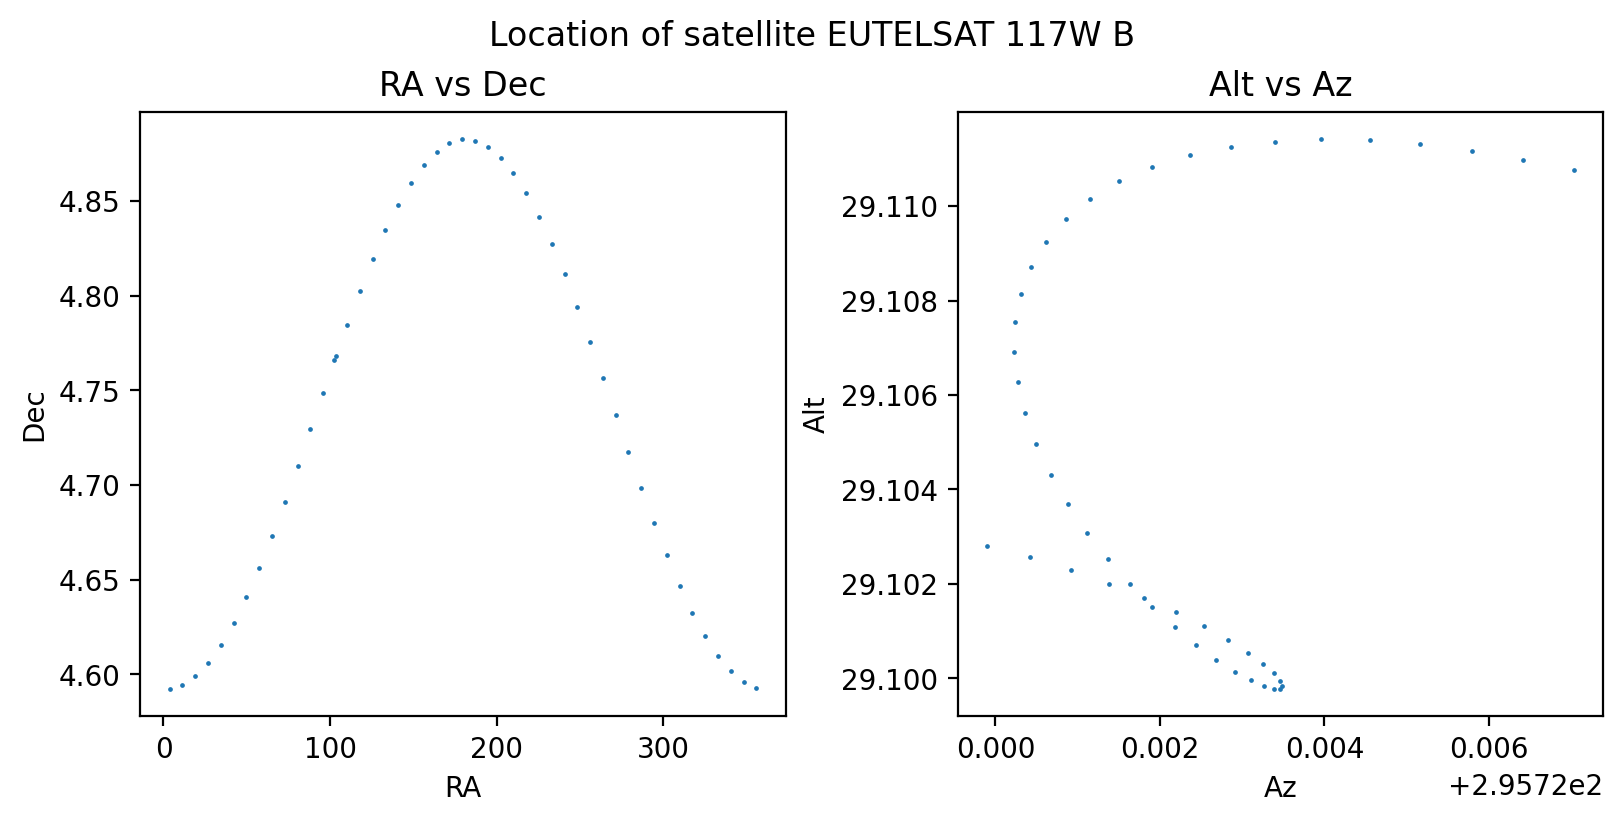

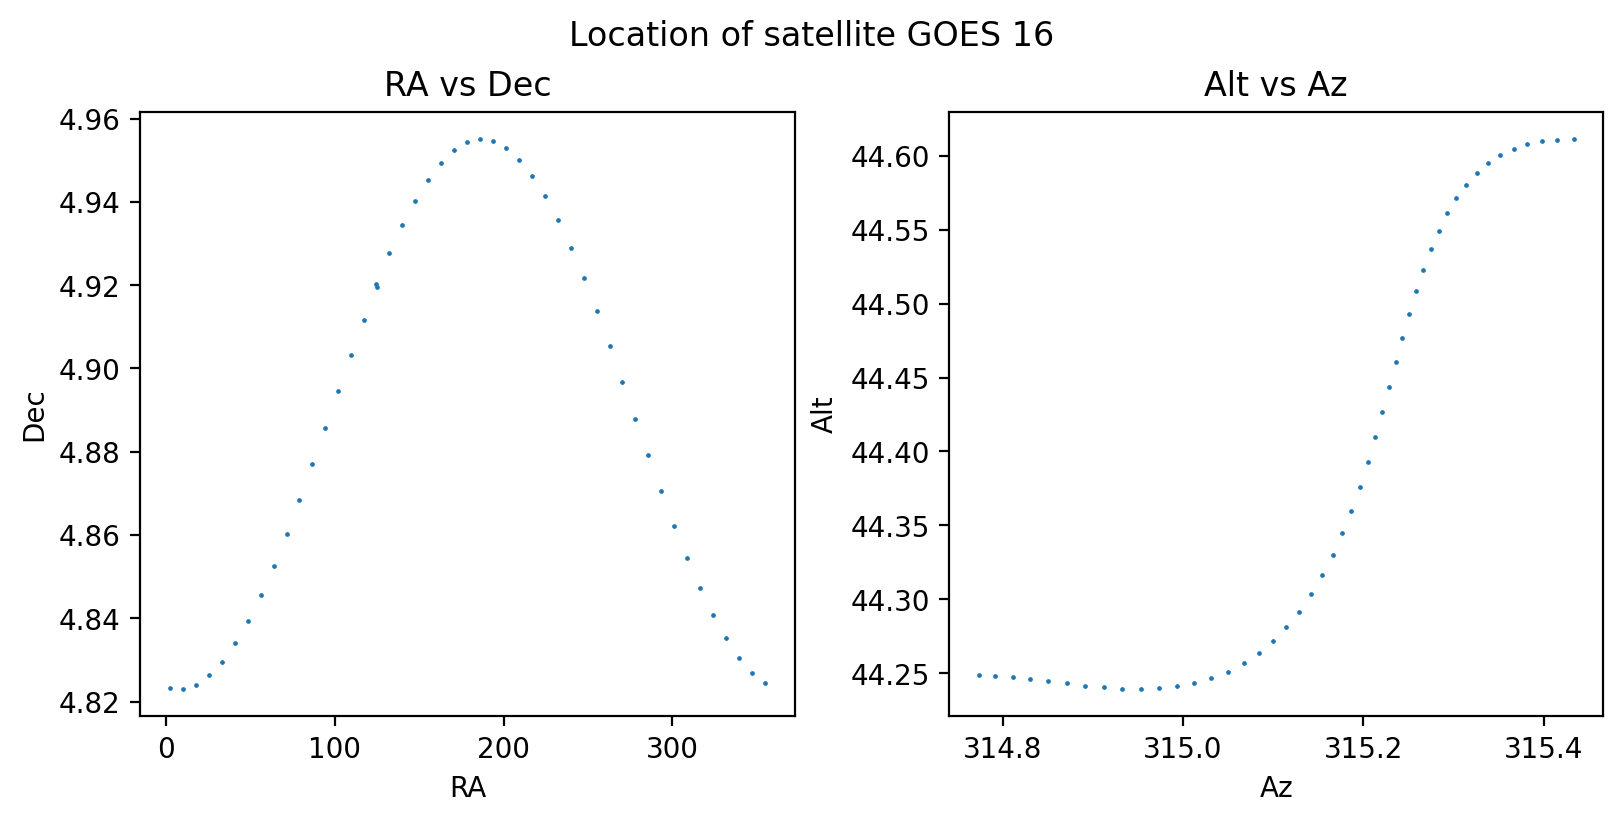

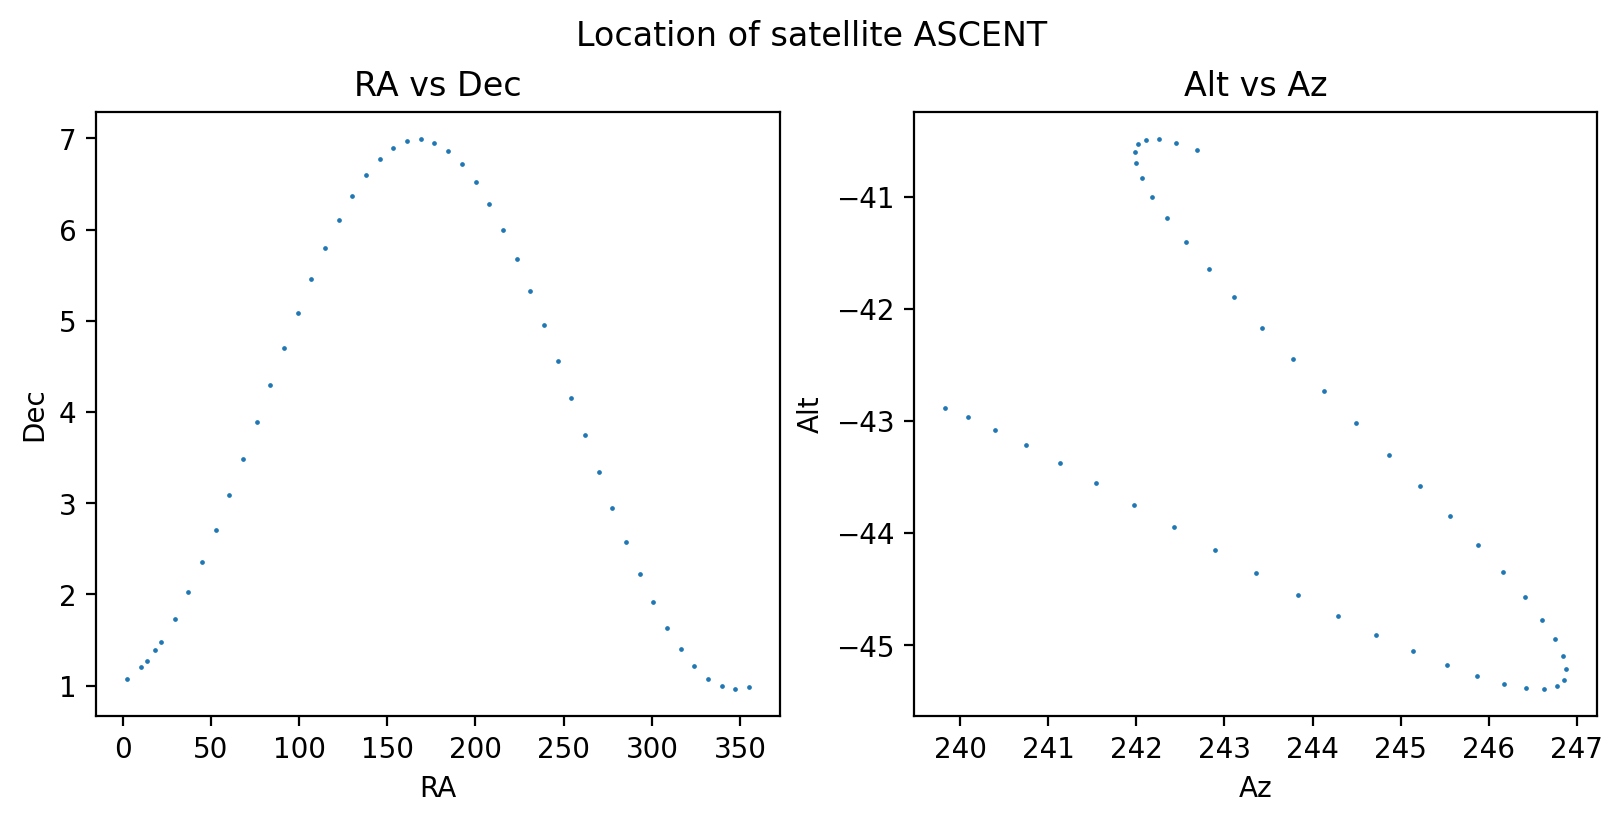

In [9]:
def plot_satellite(name, ra, dec, alt, az):
    fig, axes = plt.subplot_mosaic('AB', constrained_layout=True, figsize=(8,4))
    fig.suptitle(f'Location of satellite {name}')

    axes['A'].scatter(ra._degrees, dec.degrees, marker=".", s=2.0)
    axes['B'].scatter(az.degrees, alt.degrees, marker=".", s=2.0)

    axes['A'].set_title('RA vs Dec')
    axes['B'].set_title('Alt vs Az')

    axes['A'].set_xlabel('RA')
    axes['A'].set_ylabel('Dec')

    axes['B'].set_xlabel('Az')
    axes['B'].set_ylabel('Alt')

    #axes['B'].set_xticklabels(axes['B'].get_xticklabels(), rotation = 25)

plot_satellite('EUTELSAT 117W A', eutel_a_ra, eutel_a_dec, eutel_a_alt, eutel_a_az)
plot_satellite('EUTELSAT 117W B', eutel_b_ra, eutel_b_dec, eutel_b_alt, eutel_b_az)
plot_satellite('GOES 16', goes_16_ra, goes_16_dec, goes_16_alt, goes_16_az)
plot_satellite('ASCENT', ascent_ra, ascent_dec, ascent_alt, ascent_az)


In [10]:
# Put in specific time to Check

#time_check = ts.now()
time_check = start

# On the 22nd

# time_check = ts.tai(2024, 4, 23, 1, 17, 20.902)  # 23 BEG

# On the 23rd

#time_check = ts.tai(2024, 4, 24, 0, 25, 53.701) # 06

#time_check = ts.tai(2024, 4, 24, 0, 31, 5.190)  # 26 BEG
#time_check = ts.tai(2024, 4, 24, 0, 31, 11.420)  # 26 END

#time_check = ts.tai(2024, 4, 24, 0, 31, 14.430)   # 27 BEG
#time_check = ts.tai(2024, 4, 24, 0, 31, 20.692)   # 27 END

Azimuth: 295.7199 Altitude: 29.1028  Distance: 38686.84796819955 km


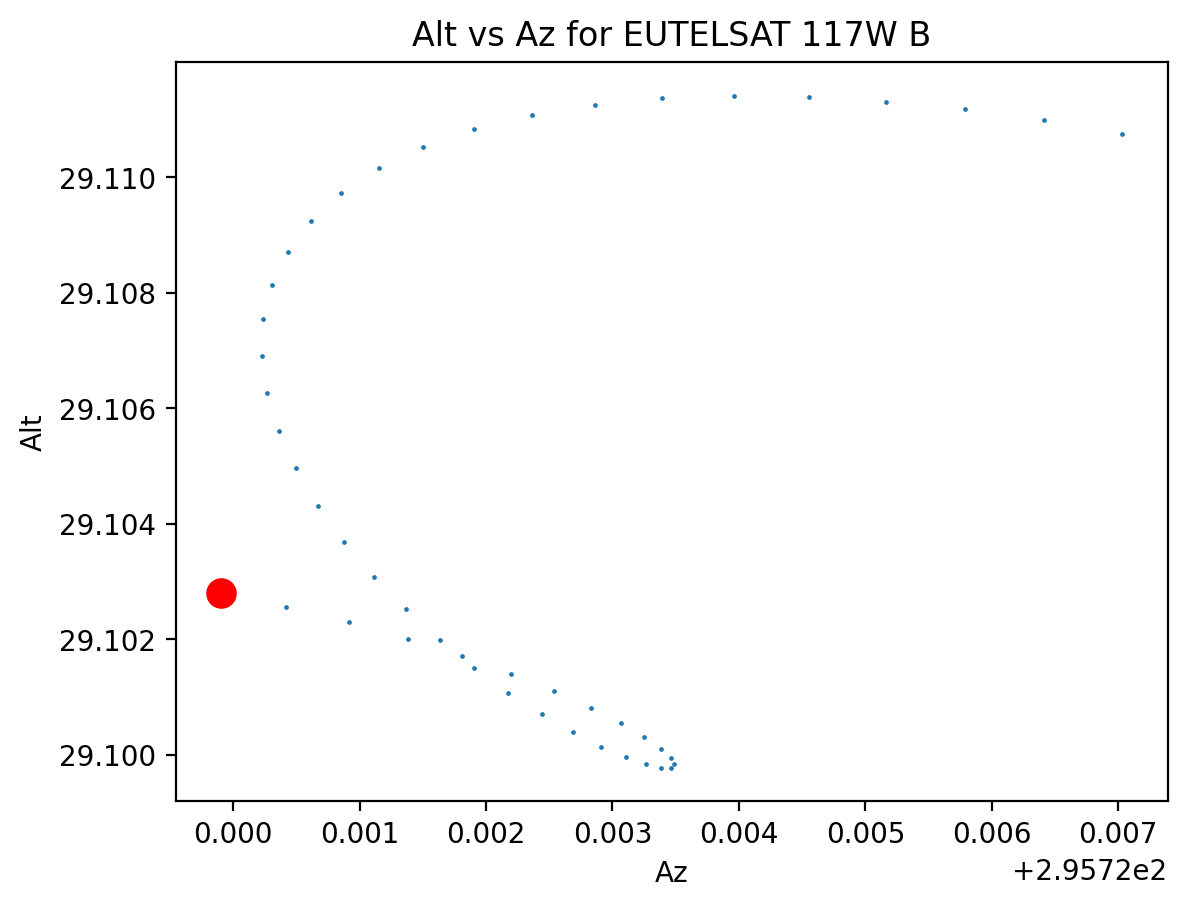

In [11]:
# Where is EutelSat 117B right now 
plt.scatter(eutel_b_az.degrees, eutel_b_alt.degrees, marker=".", s=2.0)

alt, az, dist = (eutel_sat_b - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for EUTELSAT 117W B')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

Azimuth: 315.4333 Altitude: 44.6111  Distance: 37468.94415462615 km


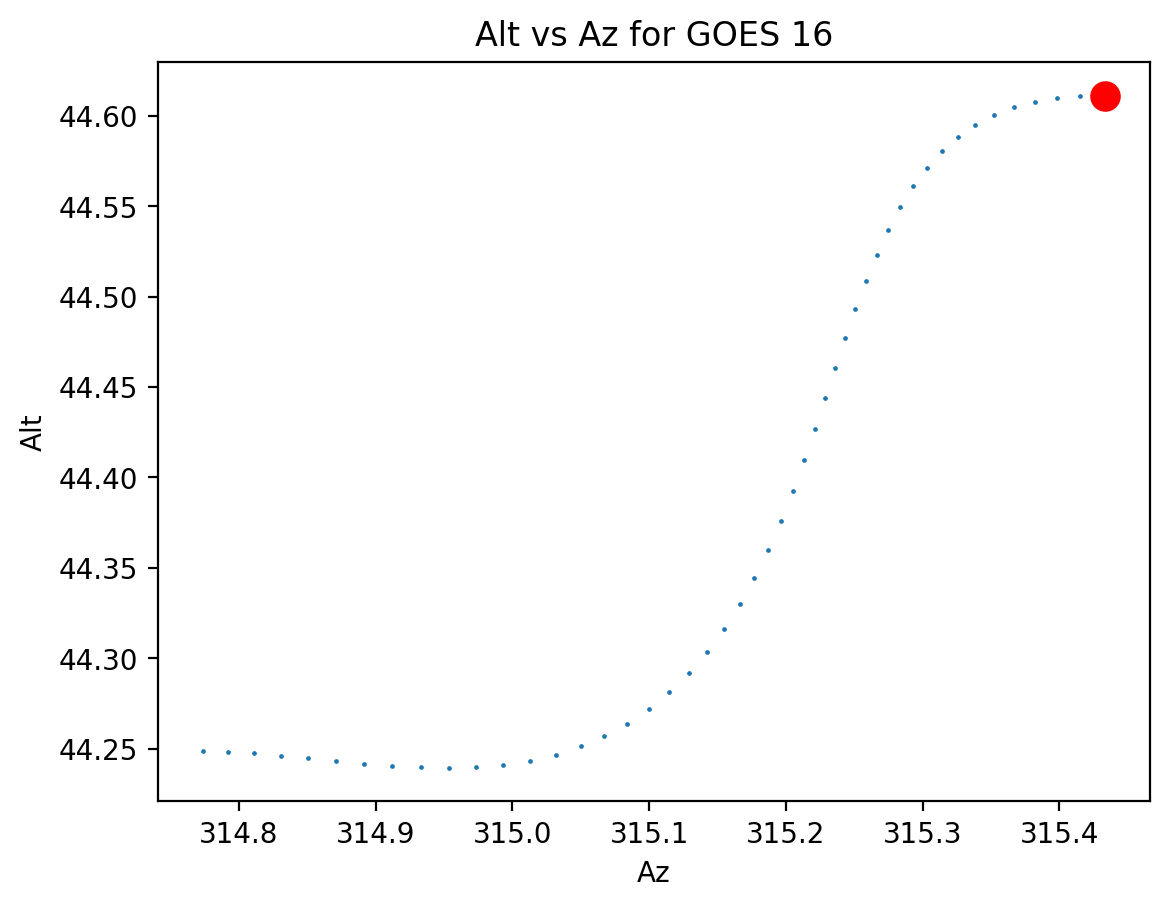

In [12]:
# Where is GOES-16 right now 
plt.scatter(goes_16_az.degrees, goes_16_alt.degrees, marker=".", s=2.0)

alt, az, dist = (goes_16 - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for GOES 16')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

Azimuth: 239.8251 Altitude: -42.8872  Distance: 45996.63475105607 km


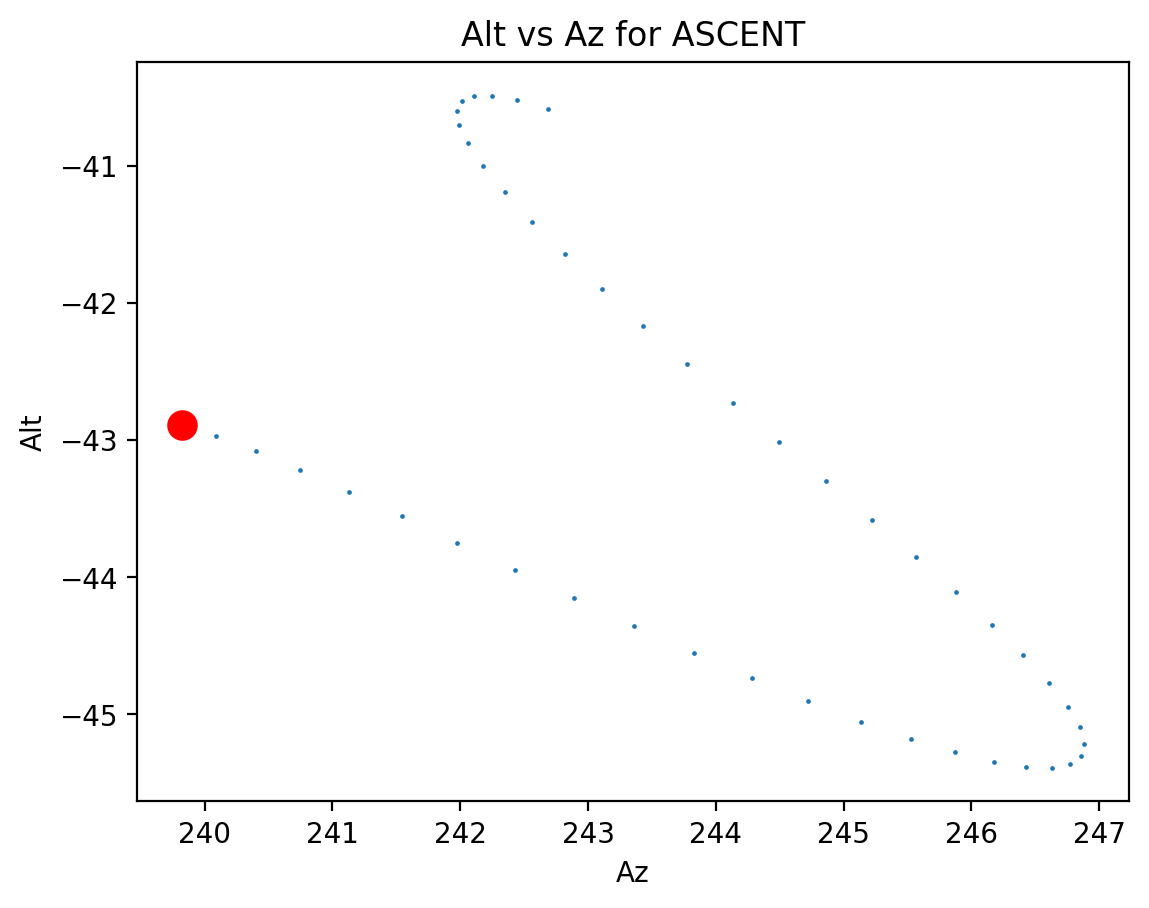

In [13]:
# Where is ASCENT right now 
plt.scatter(ascent_az.degrees, ascent_alt.degrees, marker=".", s=2.0)

alt, az, dist = (ascent - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for ASCENT')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

In [14]:
print(f'EUTELSAT_117W_A \t AZ Min:{eutel_a_az.degrees.min():4.3f} Max: {eutel_a_az.degrees.max():4.3f} \t Mean:{eutel_a_az.degrees.mean():4.3f}')
print(f'EUTELSAT_117W_A \t ALT Min:{eutel_a_alt.degrees.min():4.3f} Max: {eutel_a_alt.degrees.max():4.3f} \t Mean:{eutel_a_alt.degrees.mean():4.3f}')
print()

print(f'EUTELSAT_117W_B \t AZ Min:{eutel_b_az.degrees.min():4.3f} Max: {eutel_b_az.degrees.max():4.3f} \t Mean:{eutel_b_az.degrees.mean():4.3f}')
print(f'EUTELSAT_117W_B \t ALT Min:{eutel_b_alt.degrees.min():4.3f} Max: {eutel_b_alt.degrees.max():4.3f} \t Mean:{eutel_b_alt.degrees.mean():4.3f}')
print()

print(f'GOES_16 \t\t AZ  Min:{goes_16_az.degrees.min():4.3f} Max: {goes_16_az.degrees.max():4.3f} \t Mean:{goes_16_az.degrees.mean():4.3f}')
print(f'GOES_16 \t\t ALT Min:{goes_16_alt.degrees.min():4.3f} Max: {goes_16_alt.degrees.max():4.3f} \t Mean:{goes_16_alt.degrees.mean():4.3f}')


EUTELSAT_117W_A 	 AZ Min:295.811 Max: 295.913 	 Mean:295.864
EUTELSAT_117W_A 	 ALT Min:29.237 Max: 29.273 	 Mean:29.255

EUTELSAT_117W_B 	 AZ Min:295.720 Max: 295.727 	 Mean:295.722
EUTELSAT_117W_B 	 ALT Min:29.100 Max: 29.111 	 Mean:29.105

GOES_16 		 AZ  Min:314.774 Max: 315.433 	 Mean:315.142
GOES_16 		 ALT Min:44.239 Max: 44.611 	 Mean:44.392


In [15]:
# Satellite Position - Note manual text!

from astropy.coordinates import SkyCoord
import astropy.units as u

print('Location A:', (eutel_sat_a - Rubin).at(time_check).radec() )
print('Location B:', (eutel_sat_b - Rubin).at(time_check).radec() )
print('Location G:', (goes_16 - Rubin).at(time_check).radec() )

print( SkyCoord("06h 23m 57.11s", '+04deg 45m 29.2s',frame='icrs') )
print( SkyCoord("06h 22m 57.03s", '+04deg 45m 05.6s',frame='icrs') )
print( SkyCoord("09h 31m 18.18s", '+05deg 03m 19.2s',frame='icrs') )

Location A: (<Angle 06h 51m 07.51s>, <Angle +04deg 47' 55.7">, <Distance 0.000258457 au>)
Location B: (<Angle 06h 50m 14.40s>, <Angle +04deg 45' 57.1">, <Distance 0.000258606 au>)
Location G: (<Angle 08h 18m 35.16s>, <Angle +04deg 55' 13.1">, <Distance 0.000250464 au>)
<SkyCoord (ICRS): (ra, dec) in deg
    (95.98795833, 4.75811111)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.737625, 4.75155556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (142.82575, 5.05533333)>


In [16]:
#Satellite Location

print("*EUTEL A*")
print ((eutel_sat_a - Rubin).at(time_check).altaz()[1].degrees)
print ((eutel_sat_a - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((eutel_sat_a - Rubin).at(time_check).radec()[0]._degrees)
print ((eutel_sat_a - Rubin).at(time_check).radec()[1].degrees)

print("\n*EUTEL B*")
print ((eutel_sat_b - Rubin).at(time_check).altaz()[1].degrees)
print ((eutel_sat_b - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((eutel_sat_b - Rubin).at(time_check).radec()[0]._degrees)
print ((eutel_sat_b - Rubin).at(time_check).radec()[1].degrees)

print("\n*Goes 16*")
print ((goes_16 - Rubin).at(time_check).altaz()[1].degrees)
print ((goes_16 - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((goes_16 - Rubin).at(time_check).radec()[0]._degrees)
print ((goes_16 - Rubin).at(time_check).radec()[1].degrees)
print()

print("# 117A")
print(f'circle ({(eutel_sat_a - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(eutel_sat_a - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{EUTEL A}} color=yellow')

print("\n# 117B")
print(f'circle ({(eutel_sat_b - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(eutel_sat_b - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{EUTEL B}} color=yellow')

print("\n# GOES 16")
print(f'circle ({(goes_16 - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(goes_16 - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{GOES 16}} color=yellow')

print("\n# STARONE C3")
print(f'circle ({(starone_c3 - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(starone_c3 - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{STARONE C3}} color=yellow')

*EUTEL A*
295.9068613841276
29.254692856817073
102.78128023557618
4.798794087442164

*EUTEL B*
295.7199018992895
29.102806898109566
102.55998793558915
4.76585431994878

*Goes 16*
315.433305511636
44.61105130680559
124.64648687257574
4.920298661126312

# 117A
circle (102.78128, 4.79879, .002) # text={EUTEL A} color=yellow

# 117B
circle (102.55999, 4.76585, .002) # text={EUTEL B} color=yellow

# GOES 16
circle (124.64649, 4.92030, .002) # text={GOES 16} color=yellow

# STARONE C3
circle (149.89584, 5.10150, .002) # text={STARONE C3} color=yellow


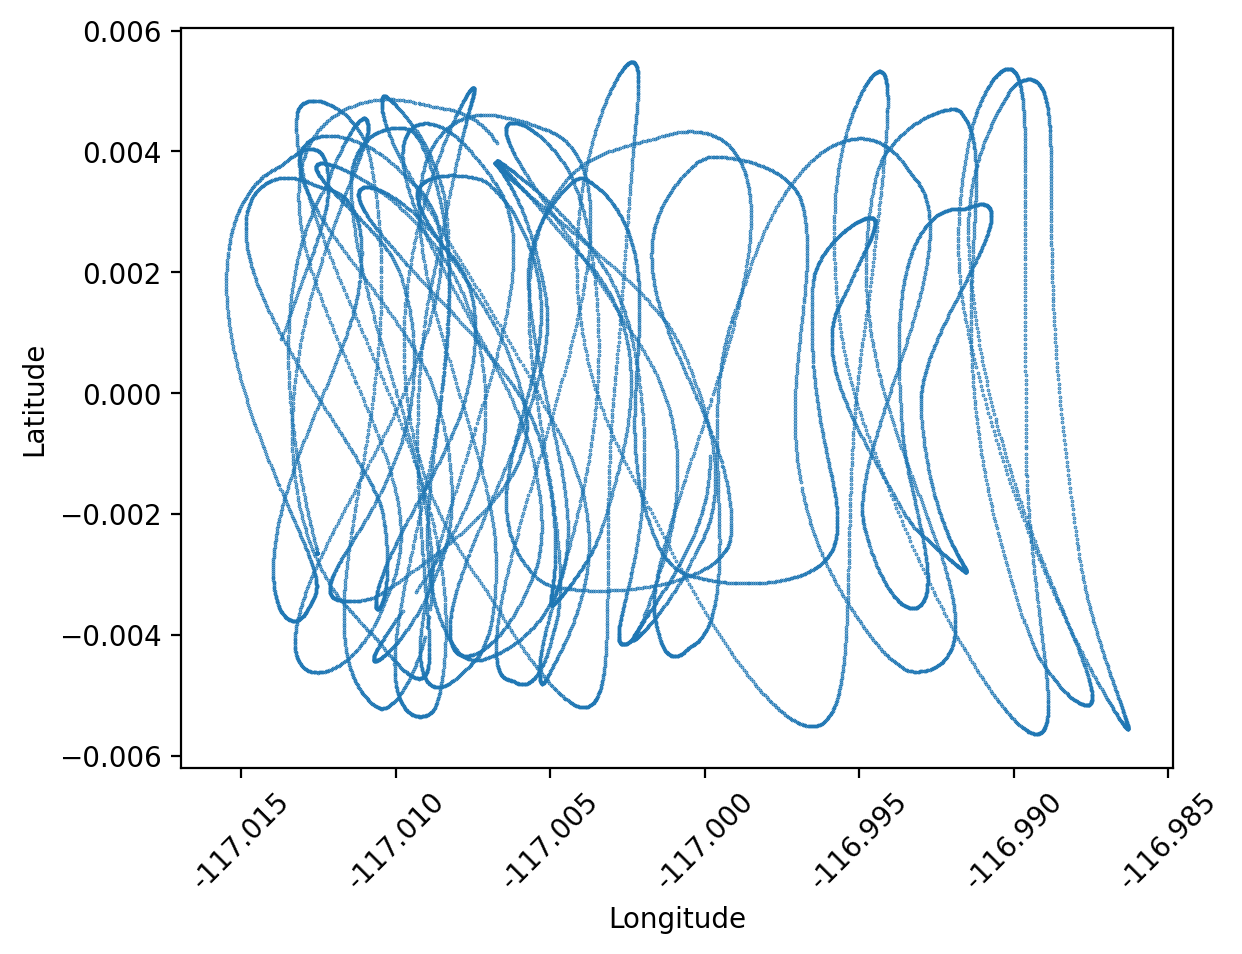

In [17]:
waas = pd.read_csv('/sdf/home/c/cwalter/waas.txt', names=['date', 'lat', 'long'], parse_dates=[0], header=None)

plt.scatter(waas.long, waas.lat, s=.1)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [18]:
def satellite_alt_az(ground_location, sat_location):
    sat_lat,sat_lon  = wgs84.latlon_of(sat_location)
    sat_elevation = wgs84.height_of(sat_location)

    ground = EarthLocation.from_geodetic(lat=Rubin.latitude.degrees, lon=Rubin.longitude.degrees, height=Rubin.elevation.m)
    sat    = EarthLocation.from_geodetic(lat=sat_lat.degrees, lon=sat_lon.degrees, height=sat_elevation.m)

    result = sat.get_itrs().transform_to(AltAz(location=ground))
    return result.alt.dms, result.az.dms

pos_now = eutel_sat_b.at(time_check)
satellite_alt_az(Rubin, pos_now)

(dms_tuple(d=29.0, m=6.0, s=11.959860217769744),
 dms_tuple(d=295.0, m=43.0, s=11.316388118730174))

In [19]:
waas_lat = waas['lat']
waas_lon = waas['long']
waas_elevation = wgs84.height_of(pos_now) # Not right...

ground = EarthLocation.from_geodetic(lat=Rubin.latitude.degrees, lon=Rubin.longitude.degrees, height=Rubin.elevation.m)
sat    = EarthLocation.from_geodetic(lat=waas_lat, lon=waas_lon, height=waas_elevation.m)
print(waas_elevation.m)
result = sat.get_itrs().transform_to(AltAz(location=ground))
result.alt[-1].dms, result.az[-1].dms


35785680.72704211


(dms_tuple(d=29.0, m=5.0, s=48.61837201841297),
 dms_tuple(d=295.0, m=42.0, s=45.63263573361837))

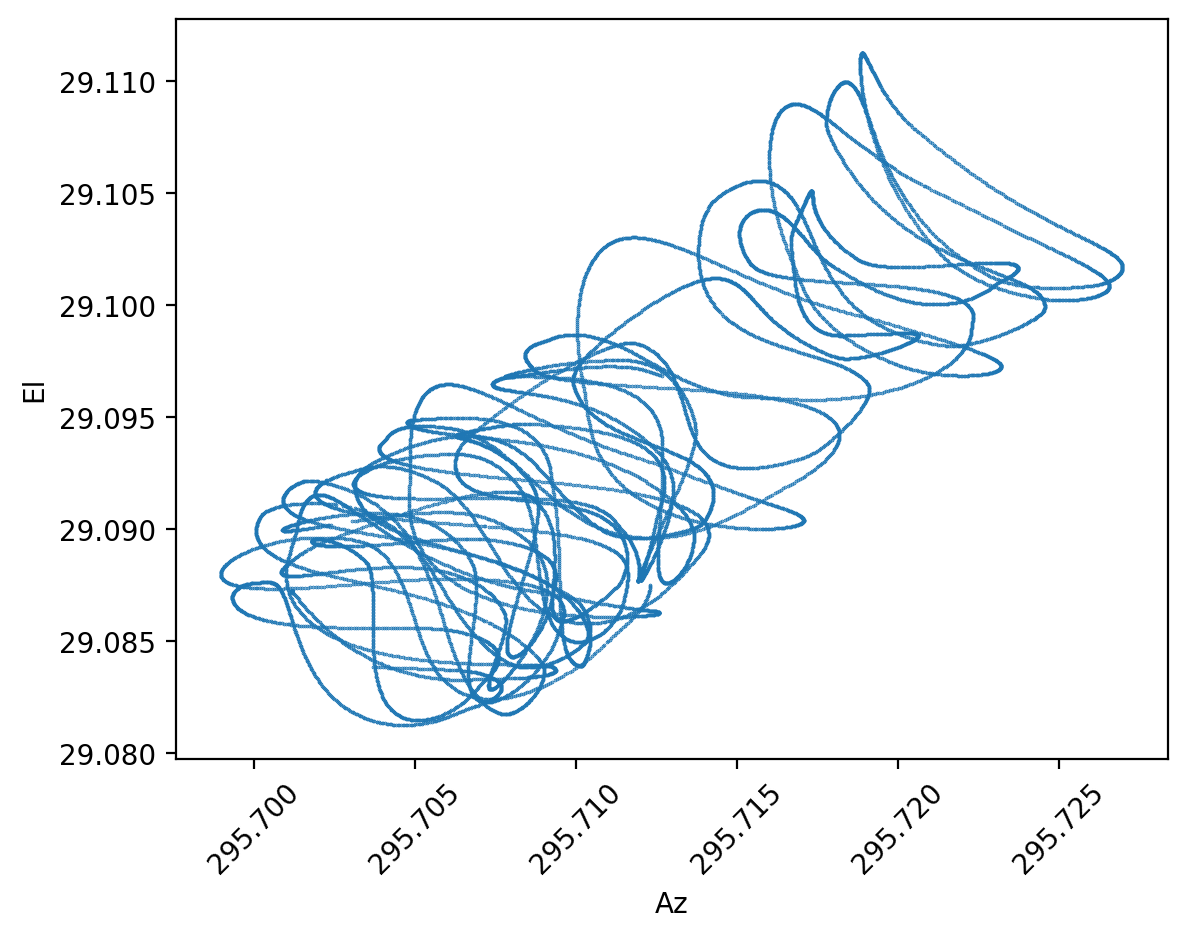

In [20]:
plt.scatter(result.az.deg, result.alt.deg, s=.1)
#plt.scatter(eutel_b_az.degrees, eutel_b_alt.degrees, marker=".", s=2.0)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
plt.gca().yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
plt.xlabel('Az')
plt.ylabel('El');

In [21]:
print(f'EUTELSAT_117W_B \t AZ Min:{result.az.deg.min():4.3f} Max: {result.az.deg.max():4.3f} \t Mean:{result.az.deg.mean():4.3f}')
print(f'EUTELSAT_117W_B \t ALT Min:{result.alt.deg.min():4.3f} Max: {result.alt.deg.max():4.3f} \t Mean:{result.alt.deg.mean():4.3f}')

print()


EUTELSAT_117W_B 	 AZ Min:295.699 Max: 295.727 	 Mean:295.711
EUTELSAT_117W_B 	 ALT Min:29.081 Max: 29.111 	 Mean:29.093



In [22]:
old_way = (eutel_sat_b - Rubin).at(time_check).altaz()

de421 = load('de421.bsp')
Earth = de421['earth']

ssb_rubin = Earth + Rubin
ssb_eutelsat = Earth + eutel_sat_b

new_way = ssb_rubin.at(time_check).observe(ssb_eutelsat).apparent().altaz()

print(old_way)
print(new_way)

[#################################] 100% de421.bsp


(<Angle 29deg 06' 10.1">, <Angle 295deg 43' 11.6">, <Distance 0.000258606 au>)
(<Angle 29deg 06' 08.6">, <Angle 295deg 43' 10.3">, <Distance 0.000258622 au>)


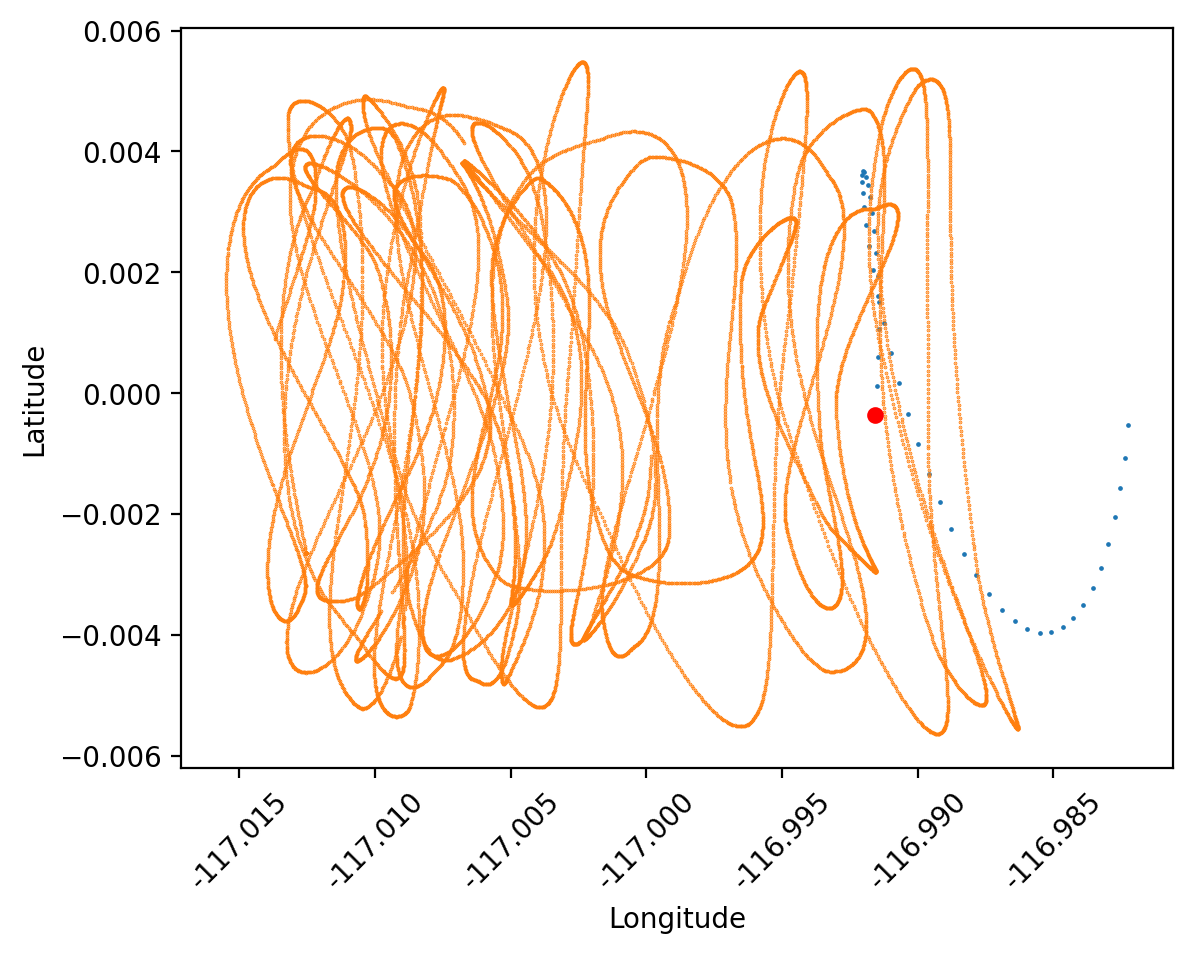

In [23]:
sat_b_pos = (eutel_sat_b).at(time_array)
sat_b_lat, sat_b_lon= wgs84.latlon_of(sat_b_pos)

plt.scatter(sat_b_lon.degrees, sat_b_lat.degrees, marker=".", s=2.0) 
plt.scatter(waas.long, waas.lat, s=.1)

sat_b_now = (eutel_sat_b).at(time_check)
now_lat, now_lon= wgs84.latlon_of(sat_b_now)
plt.plot(now_lon.degrees, now_lat.degrees, marker='o', markersize=5, color='red')

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
plt.xlabel('Longitude')
plt.ylabel('Latitude');


In [24]:
now_lon.degrees - waas.long.iloc[-1]

0.008262712850509502

In [25]:
(now_lon.degrees - waas.long.iloc[-1])* np.pi/180 * 35786

5.160754327477444

In [26]:
now_lat.degrees, now_lon.degrees

(-0.00036090824282964534, -116.99156528714948)

In [27]:
(result.az.deg[-1] - eutel_b_az.degrees[-1]) * np.pi/180 * 35786

-8.967266107095842